In [1]:
import pandas as pd
import numpy as np
from PIL import Image 

In [2]:
import matplotlib.pyplot as plt
from scipy import polyval, polyfit
%matplotlib inline 

In [45]:
im = Image.open('SEISMIC-CUT.jpg') 
rgb_im = im.convert('RGB') 
arr = np.array(rgb_im) 
 
x_size = len(arr) 
y_size = len(arr[0]) 
 
df = pd.DataFrame.from_records(arr) 


In [46]:
y_pix = df.shape[0]
x_pix = df.shape[1]

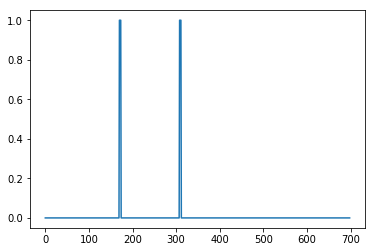

In [47]:
#let's find where yellow and orange lines are

df_color = df.applymap(lambda x: ((x[0]>200)&(x[1]>200)&(x[2]<100))|((x[0]>200)&(x[1]<200)&(x[1]>100)&(x[2]<100)))
df_color = df_color.replace([False, True], [0, 1])
plt.plot(df_color.iloc[:, 400])
plt.show()

In [48]:
# they are thick in some spots, so let's shift our pic on one pixel and substract. 
#This way 1 is a start of line and -1 is an end
df1 = df_color.iloc[1:, :].reset_index()
df2 = df_color.iloc[:-1, :].reset_index()
delta = (df1-df2)


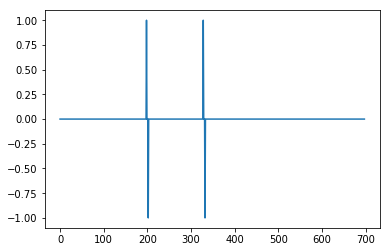

In [49]:
plt.plot(delta.iloc[:, 50])
plt.show()

In [50]:
#Now we are looking for yhe middle of these lines

hor = delta.copy()
horizon = []

for j in range(hor.shape[1]):
    a = 0
    b = 0
    col = hor.iloc[:, j]
    hor_x = []
    for i in range(hor.shape[0]):
        if (col[i]==1):
            a = i
        elif (col[i]==-1):
            b = i
            hor_x.append((a+b)/2)
    horizon.append(hor_x)

In [58]:
horizon_df = pd.DataFrame(data = horizon, columns=['top', 'bottom']).drop([0], axis = 0).dropna()

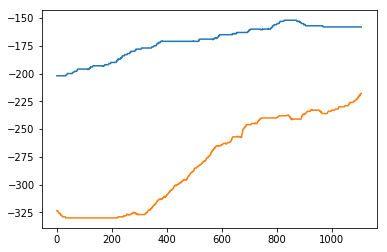

In [59]:
plt.plot(-horizon_df)
plt.show()

In [60]:
total_depth = 14000
resolution = total_depth/y_pix
resolution

20.028612303290416

In [61]:
#horizon_df.to_csv('horizon.csv', index = False)

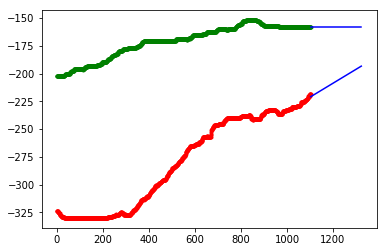

In [62]:
#here we make linear extrapolation using the last 10% of data


l = len(horizon_df)
n = l//10
x = np.linspace(l-n, l, n)
xl = np.linspace(0, l, l)
y1 = -horizon_df.iloc[-n:,0]
y2 = -horizon_df.iloc[-n:,1]

z1 = polyfit(x, y1, 1)
z2 = polyfit(x, y2, 1)


# now use the model polynomial to generate y values based on x values outside 
# the range of the original data:
x_out = np.linspace(l, l+2*n, 2*n)   # choose 20 points, 10 in, 10 outside original range
y_pred1 = polyval(z1, x_out)
y_pred2 = polyval(z2, x_out)

# now plot the original data points and the polynomial fit through them
fig = plt.figure()

ax1 = fig.add_subplot(111)
ax1.plot(xl, -horizon_df.iloc[:,0], 'g.', x_out, y_pred1, 'b-', xl, -horizon_df.iloc[:,1], 'r.', x_out, y_pred2, 'b-' )



plt.show()

In [63]:
y_pred = np.c_[y_pred1, y_pred2]
horizon = np.concatenate([-horizon_df, y_pred])

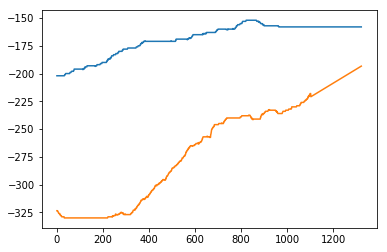

In [64]:
plt.plot(horizon)
plt.show()


In [167]:
total = pd.DataFrame(data = -horizon, columns=['top', 'bottom']).dropna()
total_m = total*resolution

In [168]:
print(total_m.iloc[328, :])

top       3545.064378
bottom    6509.298999
Name: 328, dtype: float64


In [169]:
total_m.to_csv('horizon_extra_m.csv', index = False)

In [180]:
wella_up = pd.read_csv('WellAUpscaled.csv')
wellb_up = pd.read_csv('WellBUpscaled.csv')

well_a = 328
well_b = 1006

In [181]:
core_a = wella_up['Lithology'].replace(['sandstone', 'shale'], [0,1])

In [182]:
core_b = wellb_up['Lithology'].replace(['sandstone', 'shale'], [0,1])

In [255]:
border_a = []
flag = core_a[0]
for i in range(len(core_a)):    
    if (core_a[i]!=flag):
        border_a.append(wella_up.Tops[i])
        flag = core_a[i]
border_a -= wella_up.Tops[0]-total_m.top[well_a]

In [184]:
border_b = []
flag = core_b[0]
for i in range(len(core_b)):    
    if (core_b[i]!=flag):
        border_b.append(wellb_up.Tops[i])
        flag = core_b[i]
border_b -= wellb_up.Tops[0]-total_m.top[well_b]

In [185]:
#these functions transform borders coordinates to interval (0,1) and back to normal according to actual depths of horizons 

def borders_scaled(borders, top, bottom):
    return (borders-top)/(bottom-top)
def next_borders(borders_s, top, bottom):
    return (borders_s*(bottom-top)+top)    

In [219]:
top_a = total_m.top[well_a]
bottom_a = total_m.bottom[well_a]
b_a = borders_scaled(border_a, top_a, bottom_a)

borders1 = next_borders(b_a, total_m.top[0], total_m.bottom[0])

for i in range(1, len(total_m)):
    b_next = next_borders(b_a, total_m.top[i], total_m.bottom[i])
    borders1 = np.c_[borders1, b_next]
borders1 = pd.DataFrame(data = borders1) #here: columns are borders



In [188]:
top_b = total_m.top[well_b]
bottom_b = total_m.bottom[well_b]
b_b = borders_scaled(border_b, top_b, bottom_b)

borders2 = border_b

for i in range(len(total_m)):
    b_next = next_borders(b_b, total_m.top[i], total_m.bottom[i])
    borders2 = np.c_[borders2, b_next]
borders2 = pd.DataFrame(data = borders2) #here: columns are borders



(52, 1323) (46, 1324)


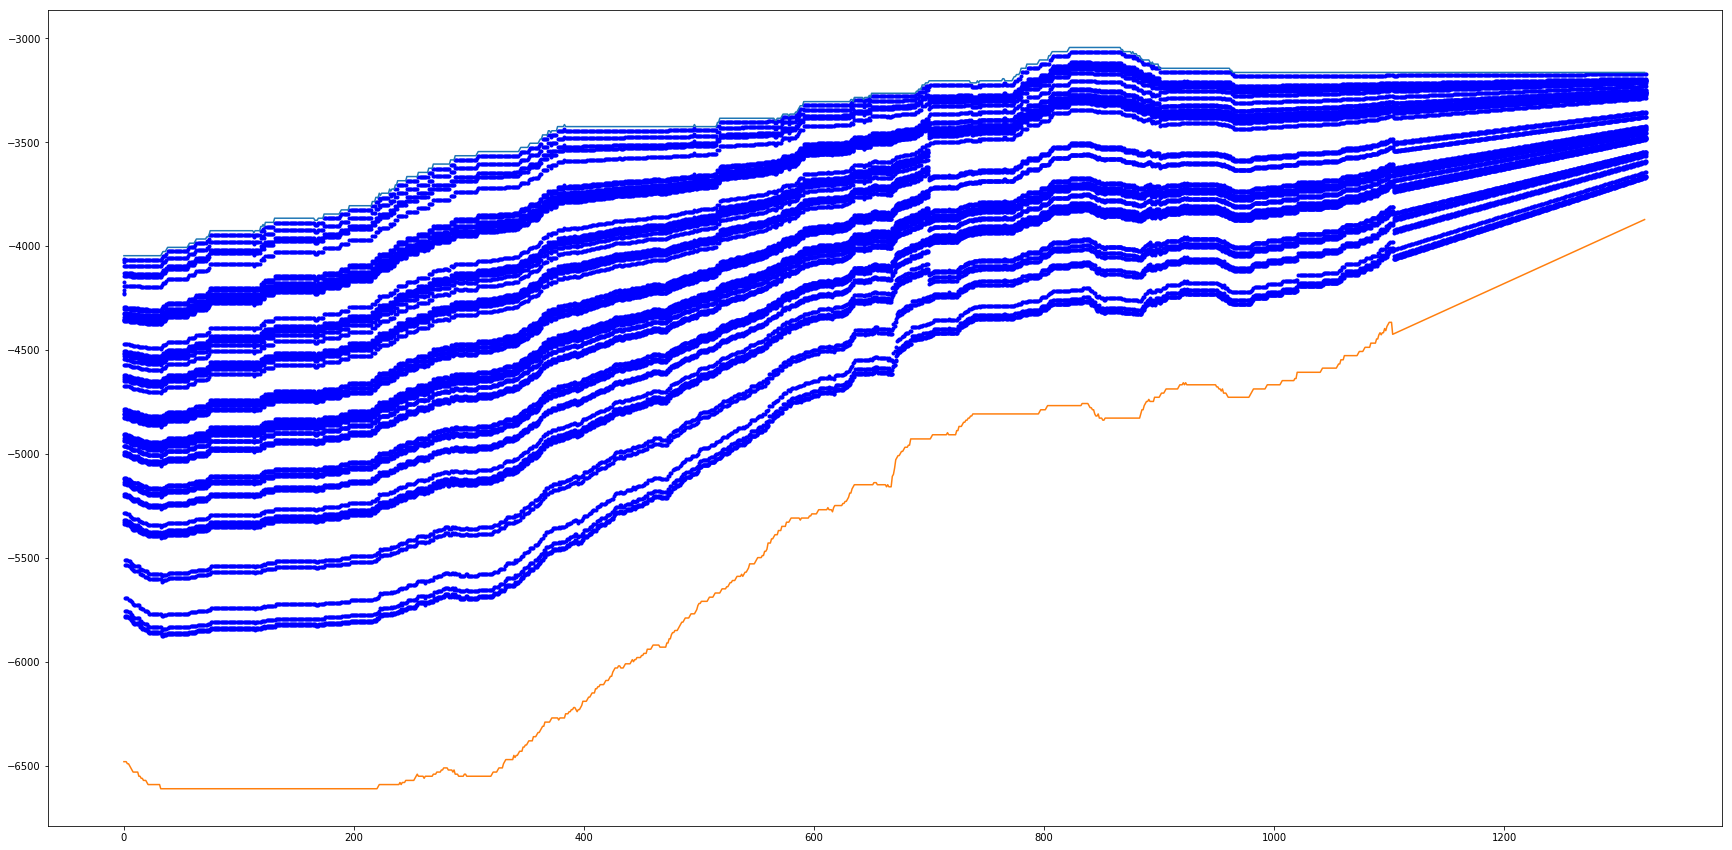

In [253]:
cut = 700


fig = plt.figure(figsize=(30,15))

ax1 = fig.add_subplot(111)
ax1.plot(-borders1.iloc[:, :cut].T, 'b.')
ax1.plot(-borders2.iloc[:40, cut:].T, 'b.')
ax1.plot(-borders2.iloc[40:, :].T, 'b.')
ax1.plot(-total_m)

plt.savefig('blue borders trans.png', transparent=True)
plt.savefig('blue borders white.png')

plt.show()